In [19]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import (
    SegformerForImageClassification,
    SegformerImageProcessor,
    SegformerConfig
)
from datasets import load_dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm import tqdm
#import cv2
import slic_processor

# Add devices
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available. Using MPS device.")
else:
    device = torch.device("cuda")
    print(torch.cuda.is_available())
    print(device)


label_df = pd.read_csv('Filtered_Data_Entry_DS541.csv')
label_df = label_df.rename(columns={'Unnamed: 0': 'full_index'})
num_labels_per_row = label_df[label_df.columns.drop(['full_index', 'id', 'subj_id'])].sum(axis=1)
avg_num_labels_per_row = np.mean(num_labels_per_row.values[:-1])  # Exclude No Finding

image_info_df = pd.read_csv('Data_Entry_2017_v2020.csv')


# Filing

all_file_names = []
with open('all_list.txt', 'r') as txtfile:
    for line in txtfile:
        all_file_names.append(line.strip())

train_val_files = os.listdir('train_val_images')
test_files = os.listdir('test_images')

# Label Maps: 
labels = label_df.columns.drop(['full_index', 'id', 'subj_id']) 

# Training and validation setup
train_val_df = label_df[label_df['id'].isin(train_val_files)][label_df.columns.drop(['full_index', 'subj_id'])]
train_val_image_paths = [os.path.join('train_val_images', file) for file in train_val_df.loc[:, 'id'].values]
train_val_labels = train_val_df.iloc[:, 1:].values 

train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(
    train_val_image_paths, train_val_labels, test_size=0.2, random_state=42
)

# Testing
test_df = label_df[label_df['id'].isin(test_files)][label_df.columns.drop(['full_index', 'subj_id'])]
test_image_paths = [os.path.join('test_images', file) for file in test_df.loc[:, 'id'].values]
test_labels = test_df.iloc[:, 1:].values

True
cuda


In [21]:
# Model Creation
def convert_to_rgb(image_path, size=512):
    image = Image.open(image_path).convert("RGB")
    if size:
        image = image.resize((size, size))
    return image

class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, image_processor, size=512):
        self.image_paths = image_paths
        self.labels = labels  # Multi-label format: list of lists or arrays
        self.image_processor = image_processor
        self.size = size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Convert the image to RGB and resize
        image = convert_to_rgb(self.image_paths[idx], size=self.size)
        
        # Convert the image to the format expected by the image processor
        inputs = self.image_processor(images=image, return_tensors="pt")
        
        # Get the label (convert to a multi-label binary vector if not already)
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        
        return {**inputs, "labels": label}

In [23]:
# Dataloaders and model instantiation
image_processor = SegformerImageProcessor(do_resize=True, size=512)

#image_processor = slic_processor

train_dataset = ImageDataset(
    image_paths=train_image_paths,
    labels=train_labels,
    image_processor=image_processor
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = ImageDataset(
    image_paths=val_image_paths,
    labels=val_labels,
    image_processor=image_processor
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = ImageDataset(
    image_paths=test_image_paths,
    labels=test_labels,
    image_processor=image_processor
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
num_classes = len(labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = SegformerConfig.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
config.output_hidden_states = True
config.num_labels = num_classes

model = SegformerForImageClassification.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
     config=config
).to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

Some weights of SegformerForImageClassification were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
def evaluate_model(model, val_loader, loss_fn):
    model.eval()  # Set model to evaluation mode

    
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # No gradient computation for validation
        for batch in val_loader:
            inputs = batch["pixel_values"].squeeze(1)  # Shape: (batch_size, 3, H, W)
            labels = batch["labels"]  # Shape: (batch_size, num_classes)
            
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            outputs = model(pixel_values=inputs)
            logits = outputs.logits  # Shape: (batch_size, num_classes)

            # Compute loss
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            # For multi-label classification, calculate accuracy
            preds = (torch.sigmoid(logits) > 0.5).int()
            correct_predictions += (preds == labels).all(dim=1).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(val_loader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

In [28]:


def compute_cam(feature_map, classifier_weights, class_idx):
    """
    Compute Class Activation Map (CAM).
    Args:
        feature_map (torch.Tensor): Shape (batch_size, channels, H, W)
        classifier_weights (torch.Tensor): Shape (num_classes, channels)
        class_idx (torch.Tensor): Class indices for each batch
    Returns:
        List[torch.Tensor]: CAM for each image in the batch
    """
    cams = []
    for idx, f_map in enumerate(feature_map):
        weights = classifier_weights[class_idx[idx]]  # Shape: (channels,)
        cam = torch.einsum("c,hwl->hwl", weights, f_map)  # Weighted sum
        cam = torch.relu(cam)  # Apply ReLU
        cams.append(cam)
    return cams

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KeyboardInterrupt: 

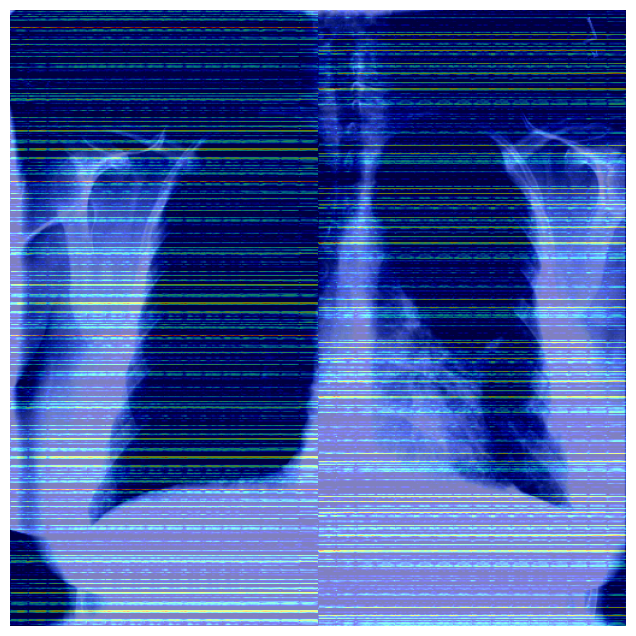

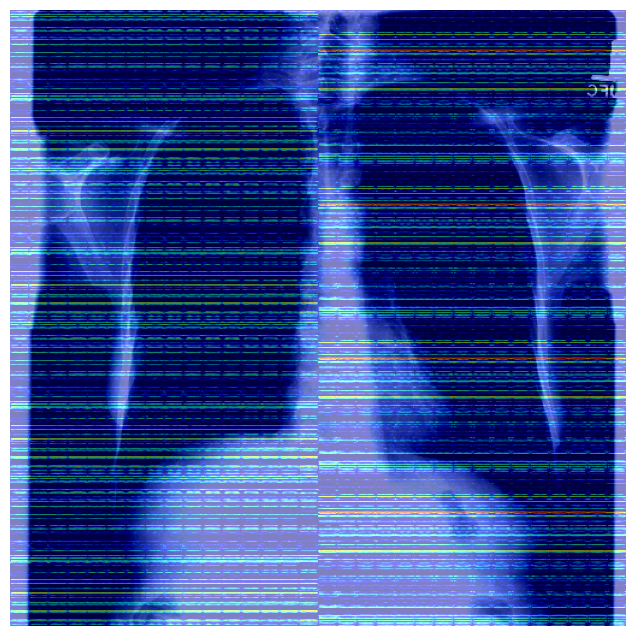

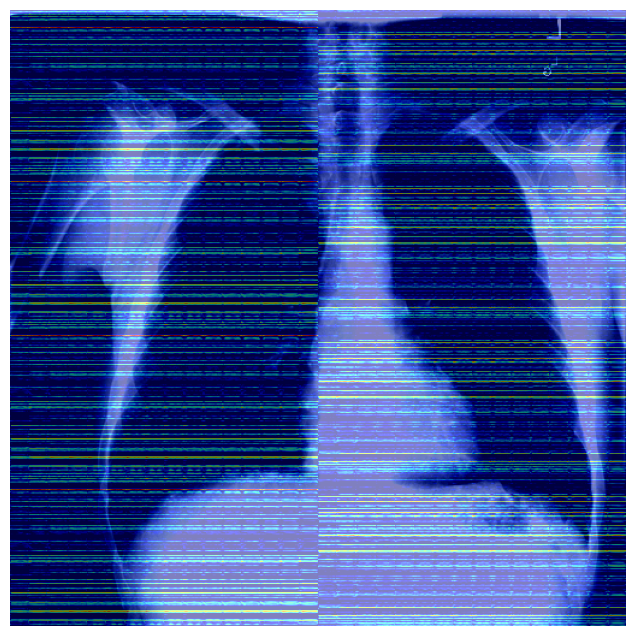

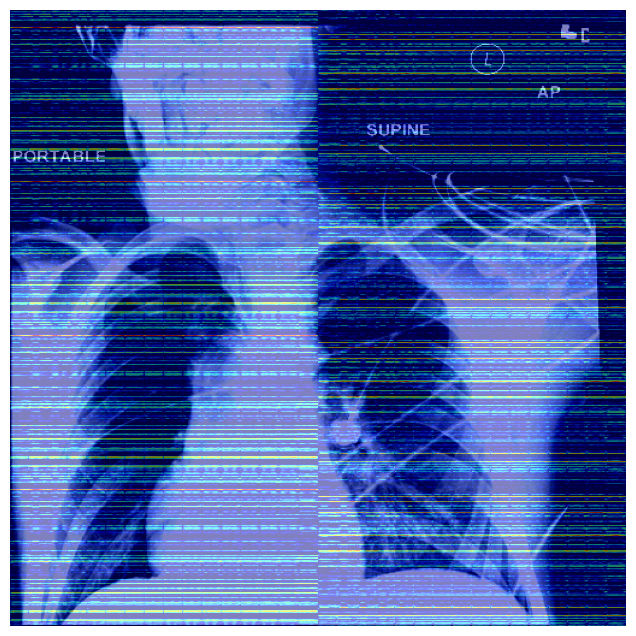

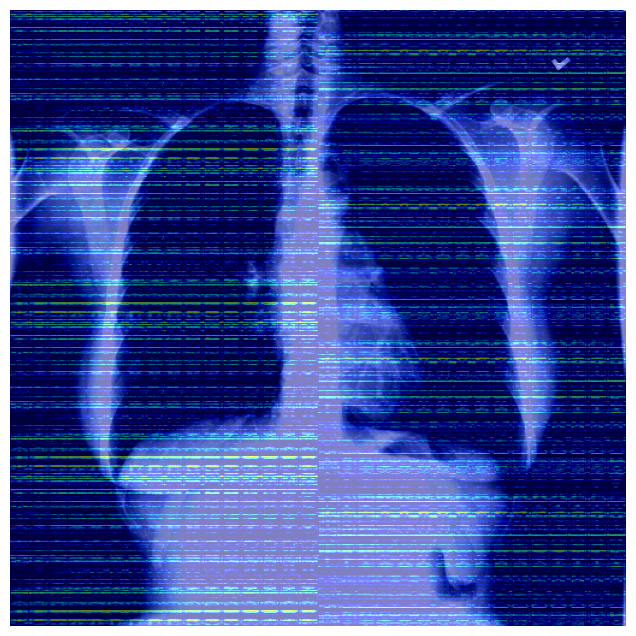

In [29]:
import matplotlib.pyplot as plt
import numpy as np


# Training, validation loop: 
best_val_loss = float('inf')  # Track the best validation loss
classifier_weights = model.classifier.weight.data  # Extract classifier weights

for epoch in range(5):  # Number of epochs
    model.train()  # Set model to training mode
    total_train_loss = 0.0

    for batch_idx, batch in enumerate(train_loader):
        inputs = batch["pixel_values"].squeeze(1)  # Shape: (batch_size, 3, H, W)
        labels = batch["labels"]  # Shape: (batch_size, num_classes)

        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(pixel_values=inputs)
        logits = outputs.logits  # Shape: (batch_size, num_classes)

        # Compute loss
        loss = loss_fn(logits, labels)
        total_train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



        # Compute CAM for the first batch in each epoch
        feature_maps = outputs.hidden_states[-1]
        if batch_idx == 0:
            with torch.no_grad():
                predicted_classes = torch.argmax(logits, dim=1)  # Get predicted classes
                cams = compute_cam(feature_maps, classifier_weights, predicted_classes)

                # Normalize and optionally visualize CAMs
                for i, cam in enumerate(cams[:5]):  # Process first 5 CAMs
                    cam = cam.cpu().numpy()
                    cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize to [0, 1]

                    # Resize CAM to match input image size
                    input_image = inputs[i].permute(1, 2, 0).cpu().numpy()  # Convert to HWC
                    cam_resized = np.interp(cam, (cam.min(), cam.max()), (0, 1))  # Rescale CAM to [0, 1]
                    cam_resized = np.resize(cam, input_image.shape[:2])  # Resize CAM to match input image

                    # Overlay CAM on input image
                    plt.figure(figsize=(8, 8))
                    plt.imshow(input_image)
                    plt.imshow(cam_resized, cmap='jet', alpha=0.5)  # Overlay CAM with transparency
                    plt.axis('off')


    # Compute average training loss
    avg_train_loss = total_train_loss / len(train_loader)

    # Evaluate on validation set
    val_loss, val_accuracy = evaluate_model(model, val_loader, loss_fn)

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")

    print(
        f"Epoch {epoch + 1}: "
        f"Train Loss = {avg_train_loss:.4f}, "
        f"Val Loss = {val_loss:.4f}, "
        f"Val Accuracy = {val_accuracy:.4f}"
    )

In [ ]:
# Test Loop

model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model.eval()

# Initialize variables to store predictions and true labels
all_predictions = []
all_true_labels = []

# No gradient computation during evaluation
with torch.no_grad():
    for batch in test_loader:  # Iterate through the test DataLoader
        # Extract inputs and labels from the batch
        inputs = batch["pixel_values"].squeeze(1)  # Shape: (batch_size, 3, H, W)
        labels = batch["labels"]  # Shape: (batch_size, num_classes)
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward pass through the model
        outputs = model(pixel_values=inputs)
        logits = outputs.logits  # Shape: (batch_size, num_classes)

        # Apply a threshold to logits to generate binary predictions
        predictions = (torch.sigmoid(logits) > 0.5).int()

        # Collect predictions and true labels
        all_predictions.append(predictions.cpu())
        all_true_labels.append(labels.cpu())

# Concatenate all batches
all_predictions = torch.cat(all_predictions, dim=0).numpy()
all_true_labels = torch.cat(all_true_labels, dim=0).numpy()

# Compute and display classification metrics
print(classification_report(all_true_labels, all_predictions, target_names=label_map.keys()))




In [ ]:
# Confusion Matrix
cm = confusion_matrix(all_true_labels.argmax(axis=1), all_predictions.argmax(axis=1))
# Exclude the class that is not present in the true labels
class_names = list(label_map.keys())

true_labeled_classes = [class_names[i] for i in range(len(class_names)) if i != 16]

plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=true_labeled_classes, yticklabels=true_labeled_classes, cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()